## Look at Partition Performance Using ML techniques

In [131]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [132]:
%config Completer.use_jedi = False

**Extract the partitioned wave params**

In [133]:
offshore = pd.read_csv('../data/partitionedOffshore.csv', index_col = 'time', parse_dates = True)

### Method 1: 12 hr extract
We will extract the first 12 hours from each model run and treat it as a single timeseries. <br>
For the purposes of keeping things simple we will use one of the offshore site locations.

We are hypothesising two things, one the model performs best in this time range. The second is that bias against observations is likely to be smallest.

In [134]:
modgrps = offshore.groupby('ModelRun')

In [135]:
allruns12hr = []
for nm, group in modgrps:
    allruns12hr.append(group[group['site'] == 359.0].iloc[:12])

In [136]:
data12 = pd.concat(allruns12hr)

#### Let's checkout a data

<AxesSubplot:xlabel='time'>

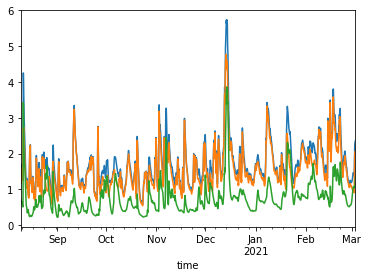

In [137]:
data12.hs.plot()
data12.hs_sa.plot()
data12.hs_sw.plot()

**Simplyfy:**
Use mean direction, remove fields we don't need and round data down to 2 decimal places. 
Why, becuase any more decimal places that this is superfluous information.

In [138]:
data12 = data12[['hs','tm02','tp','dpm','dm','hs_sa','tm02_sa','dm_sa','hs_sw','tm02_sw','dm_sw']].round(2)
data12.head(2)

,hs,tm02,tp,dpm,dm,hs_sa,tm02_sa,dm_sa,hs_sw,tm02_sw,dm_sw
time,,,,,,,,,,,
2020-08-09 10:00:00,1.42,5.53,10.48,165.81,142.85,1.24,4.98,135.42,0.74,11.17,157.76
2020-08-09 11:00:00,1.38,5.66,10.42,164.91,143.07,1.20,5.08,137.54,0.73,11.16,157.32


### Observations
Bring in some observations for the same period this will be our labels (target parameters)

In [139]:
import sqlite3
import toolBOX

In [140]:
latestObs = pd.read_csv('../data/waveObs.csv', index_col = 0, parse_dates = True)

C:\Users\Leo\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


**Filter to remove some bad obs**

In [141]:
latestObs = latestObs[latestObs['Hsig'] > 0.1]

In [142]:
Obs = latestObs[latestObs['Site'] == 'Tweed Heads Mk4']

In [143]:
Obs.index = pd.to_datetime(Obs.DateTime)

**Merge in obs from database of Obs**

In [144]:
moreObs = toolBOX.get_waveDB_xday_obs(dbpath = 'G:/SWAN/wave_obs.db', days = 900)

In [145]:
Obs = pd.concat([Obs, moreObs[moreObs['Site'] =='Tweed Heads Mk4'].loc[latestObs.index[-1]:]])

In [146]:
Obs = Obs[Obs.Hsig > 0.01]
Obs = Obs.drop_duplicates(keep = 'first')
Obs = Obs[~Obs.index.duplicated(keep = 'first')]
Obs = Obs.sort_index()

In [147]:
Obs = Obs[['Hsig','Hmax','Tp','Tz','Direction']]
Obs = Obs.resample('H').mean()
Obs = Obs.dropna()
Obs = Obs.round(2)

<AxesSubplot:xlabel='DateTime'>

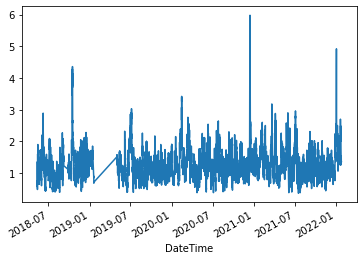

In [148]:
Obs.Hsig.plot()

### Feature Engineering
We need to prepare our data for ML models to be able to accept

In [149]:
def prepstnData(df):
    df = df.copy()
      
    df['dpm_cos'] = np.cos(np.deg2rad(df['dpm']))
    df['dpm_sin'] = np.sin(np.deg2rad(df['dpm']))
    df['dm_cos'] = np.cos(np.deg2rad(df['dm']))
    df['dm_sin'] = np.sin(np.deg2rad(df['dm']))
    df['dm_sa_cos'] = np.cos(np.deg2rad(df['dm_sa']))
    df['dm_sa_sin'] = np.sin(np.deg2rad(df['dm_sa']))
    df['dm_sw_cos'] = np.cos(np.deg2rad(df['dm_sw']))
    df['dm_sw_sin'] = np.sin(np.deg2rad(df['dm_sw']))
    
    'hs','tm02','tp','dpm','dm','hs_sa','tm02_sa','dm_sa','hs_sw','tm02_sw','dm_sw'

    df = df[['hs','tm02','dpm_cos', 'dpm_sin', 'dm_cos', 'dm_sin', 
             'hs_sa','tm02_sa','dm_sa_cos','dm_sa_sin',
             'hs_sw','tm02_sw', 'dm_sw_cos','dm_sw_sin']].copy()
    
    return df

In [150]:
data12_prep = prepstnData(data12)
data12_prep.head(2)

,hs,tm02,dpm_cos,dpm_sin,dm_cos,dm_sin,hs_sa,tm02_sa,dm_sa_cos,dm_sa_sin,hs_sw,tm02_sw,dm_sw_cos,dm_sw_sin
time,,,,,,,,,,,,,,
2020-08-09 10:00:00,1.42,5.53,-0.969488,0.245138,-0.797057,0.603904,1.24,4.98,-0.712271,0.701904,0.74,11.17,-0.925607,0.378487
2020-08-09 11:00:00,1.38,5.66,-0.965518,0.260336,-0.799370,0.600839,1.20,5.08,-0.737749,0.675075,0.73,11.16,-0.922673,0.385584


**Find overlapping features (model data) and labels (observations)**

In [151]:
data = pd.merge(Obs.Hsig, data12_prep, left_index = True, right_index = True)

In [152]:
data.tail(2)

,Hsig,hs,tm02,dpm_cos,dpm_sin,dm_cos,dm_sin,hs_sa,tm02_sa,dm_sa_cos,dm_sa_sin,hs_sw,tm02_sw,dm_sw_cos,dm_sw_sin
2021-03-03 08:00:00,1.47,2.36,6.18,-0.702153,0.712026,-0.853733,0.520712,2.03,5.50,-0.915733,0.401788,1.29,11.85,-0.771291,0.636482
2021-03-03 09:00:00,1.52,2.36,6.26,-0.759498,0.650509,-0.861097,0.508440,2.01,5.53,-0.911834,0.410560,1.33,11.80,-0.807578,0.589760


In [153]:
ind_data = data.iloc[(int(10 * len(data.index)/100))*-1:]
ml_data = data.iloc[:(int(10 * len(data.index)/100))*-1]

In [154]:
ind_data.head(2)

,Hsig,hs,tm02,dpm_cos,dpm_sin,dm_cos,dm_sin,hs_sa,tm02_sa,dm_sa_cos,dm_sa_sin,hs_sw,tm02_sw,dm_sw_cos,dm_sw_sin
2021-02-10 20:00:00,1.30,2.13,5.75,-0.836095,0.548585,-0.843485,0.537152,1.99,5.45,-0.829135,0.559048,0.86,11.55,-0.892034,0.451968
2021-02-10 21:00:00,1.27,2.15,5.80,-0.840283,0.542148,-0.847215,0.531251,2.00,5.49,-0.833114,0.553101,0.88,11.53,-0.895479,0.445104


## Finalising for the ML training

In [155]:
#sort data down to what we need, features and labels (source and target), which in this case is univariate
labels = ml_data['Hsig'].values
features = ml_data.iloc[:,1:].values

**Scaling our data**

In [156]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [157]:
from sklearn.model_selection import TimeSeriesSplit

In [229]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle = False)

In [230]:
norm_f = MinMaxScaler().fit(features)
X_train = norm_f.transform(features)
norm_l = MinMaxScaler().fit(labels.reshape(-1, 1))
y_train = norm_l.transform(labels.reshape(-1, 1))

## Training

In [231]:
from sklearn.neural_network import MLPRegressor
import pickle

In [248]:
clf_mlp1 = MLPRegressor(hidden_layer_sizes = (50,50,50,50),
                                             activation = 'relu',
                                             solver = 'adam',
                                             shuffle = False,
                                             early_stopping = False,
                                             random_state = 0)

clf_mlp2 = MLPRegressor(hidden_layer_sizes = (50,50,50,50),
                                             activation = 'relu',
                                             solver = 'adam',
                                             shuffle = False,
                                             early_stopping = True,
                                             random_state = 0)

In [286]:
tscv = TimeSeriesSplit(n_splits=int(len(X_train)/10))

In [287]:
train_index

array([   0,    1,    2, ..., 4400, 4401, 4402])

In [288]:
X__train_stream.shape

(4403, 14)

In [289]:
for train_index, test_index in tscv.split(X_train):
    X__train_stream, X_test_stream = X_train[train_index, :], y_train[train_index, :]
    clf_mlp1.partial_fit(X__train_stream, X_test_stream.ravel())

In [290]:
clf_mlp2.fit(X_train, y_train.ravel())

C:\Users\Leo\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(early_stopping=True, hidden_layer_sizes=(50, 50, 50, 50),
             random_state=0, shuffle=False)

## Make Prediction

In [291]:
hs_pred = norm_l.inverse_transform(clf_mlp1.predict(norm_f.transform(ind_data.iloc[:,1:].values)).reshape(-1,1))
hs_pred2 = norm_l.inverse_transform(clf_mlp2.predict(norm_f.transform(ind_data.iloc[:,1:].values)).reshape(-1,1))

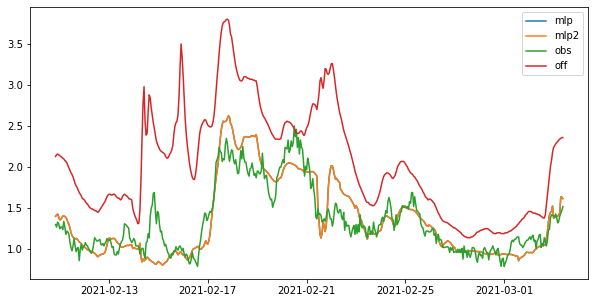

In [292]:
plt.figure(figsize = (10, 5))
plt.plot(ind_data.index, hs_pred, label = 'mlp')
plt.plot(ind_data.index, hs_pred, label = 'mlp2')
plt.plot(ind_data.index, ind_data.Hsig, label = 'obs')
plt.plot(ind_data.index, ind_data.hs, label = 'off')
plt.legend()

## Compare Performance

We also have results for a SWAN model for comparison. This model was forced by the AUSWAVE-G3 experimental model (using wave parameters to create a JONSWAP spectrum).

In [293]:
wbSWAN = pd.read_csv("../data/SWAN_wb_results_JONSWAP.csv", parse_dates = True, index_col = 0)
wbSWAN = wbSWAN2.drop_duplicates()
wbSWAN.head(2)

,% Time,Hsig,Tm02,Dir,PkDir,Watlev,Hswell,Tp_smoothed,site,site_name,lon,lat,run
Date/Time,,,,,,,,,,,,,
2021-02-10 20:00:00,20210210.20,1.45839,6.4274,125.332,122.5,0.1287,0.31696,8.2339,2,Tweed Heads WRB,153.57599,-28.181788,20210210_1200
2021-02-10 21:00:00,20210210.21,1.46114,6.4395,125.575,122.5,0.2897,0.31993,8.2400,2,Tweed Heads WRB,153.57599,-28.181788,20210210_1200


In [294]:
modgrps = wbSWAN.groupby('run')

In [295]:
allruns12hr = []
for nm, group in modgrps:
    allruns12hr.append(group[group['site_name']==' Tweed Heads WRB'].iloc[:12])
wbSWAN = pd.concat(allruns12hr)

In [296]:
wbSWAN =wbSWAN[ind_data.index[0]:ind_data.index[-1]]

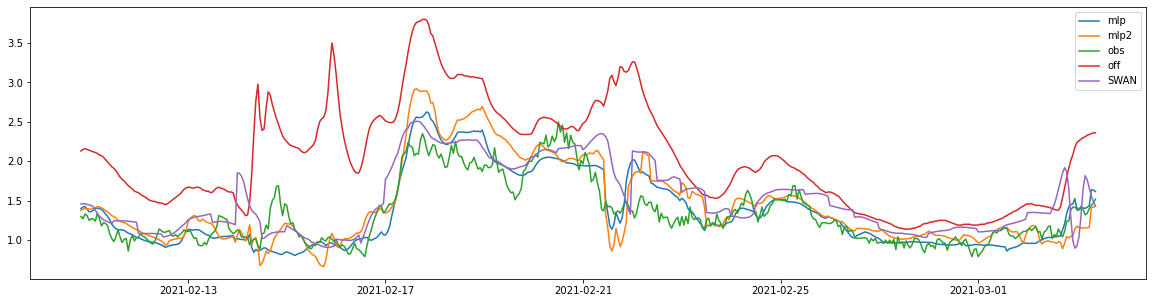

In [297]:
plt.figure(figsize =(20, 5))
plt.plot(ind_data.index, hs_pred, label = 'mlp')
plt.plot(ind_data.index, hs_pred2, label = 'mlp2')
plt.plot(ind_data.index, ind_data.Hsig, label = 'obs')
plt.plot(ind_data.index, ind_data.hs, label = 'off')
plt.plot(wbSWAN.index, wbSWAN.Hsig, label = 'SWAN')
plt.legend()